In [86]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,EarlyStopping,CSVLogger
from tensorflow.keras.models import load_model

# Helper libraries
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import os

In [75]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    as_supervised=True,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [76]:
ds_train

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

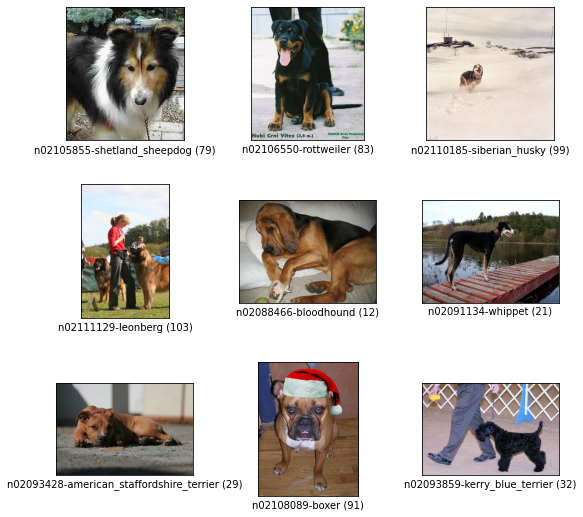

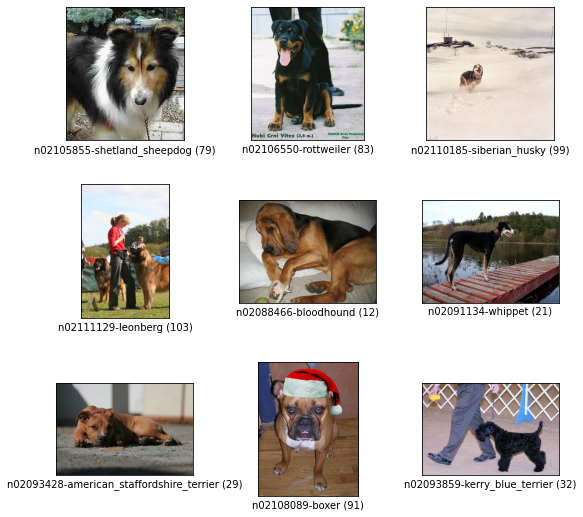

In [72]:
tfds.show_examples(ds_train, ds_info)

In [73]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

## Gaussian nosie augumentation

In [50]:
def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)  # 값을 0과 1 사이로 클리핑
    return noisy_image

In [51]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = add_gaussian_noise(image)  # 가우시안 노이즈 추가
    image = tf.clip_by_value(image, 0, 1)
    return image, label


## Cut Mix

In [52]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [53]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [54]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [55]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mix up

In [56]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [57]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [67]:
def onehot(image, label):
    if label.dtype == tf.float32:
        label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [111]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup = False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test  and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [112]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [113]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [116]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix =True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup = True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


In [118]:
ds_train_mixup

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

## Model 학습

In [21]:
checkpoint = ModelCheckpoint("resnet50_no_aug_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=False, mode='max', save_weights_only=True)
csv_logger = CSVLogger(filename = './history_resnet50_no_aug.csv',append = True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],    
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [checkpoint,csv_logger]
)

Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 2.2024 - accuracy: 0.4449 - val_loss: 3.2875 - val_accuracy: 0.2267

Epoch 00001: saving model to resnet50_no_aug_weights.h5
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 0.7369 - accuracy: 0.7993 - val_loss: 1.1184 - val_accuracy: 0.6694

Epoch 00002: saving model to resnet50_no_aug_weights.h5
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2347 - accuracy: 0.9518 - val_loss: 0.9424 - val_accuracy: 0.7224

Epoch 00003: saving model to resnet50_no_aug_weights.h5
Epoch 4/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0637 - accuracy: 0.9940 - val_loss: 0.8992 - val_accuracy: 0.7410

Epoch 00004: saving model to resnet50_no_aug_weights.h5
Epoch 5/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0265 - accuracy: 0.9993 - val_loss: 0.9048 - val_accuracy: 0.7423

Epoch 00005: saving model to resnet50_no_

## no_augmentation 그래프

Index(['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object')


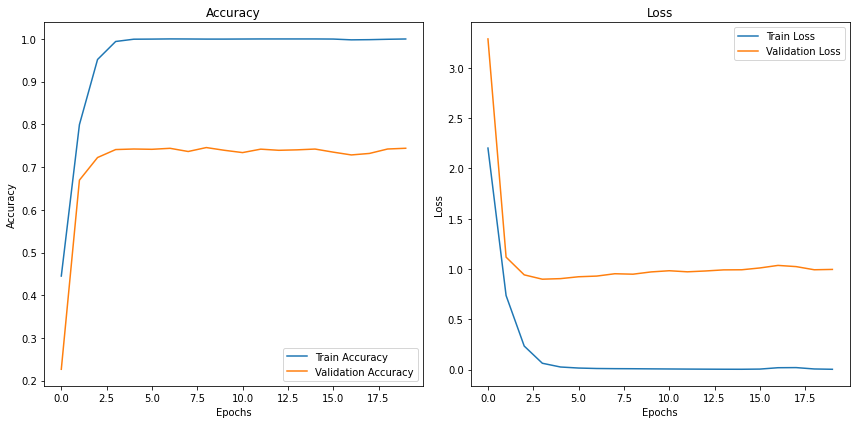

In [87]:
# CSV 파일 경로 설정
csv_file = 'history_resnet50_no_aug.csv'  # CSV Logger로 저장된 파일 경로

# CSV 파일 읽기
df = pd.read_csv(csv_file)

# 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss' 열을 확인
print(df.columns)

# 그래프 그리기
plt.figure(figsize=(12, 6))

# Train Accuracy와 Validation Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Train Loss와 Validation Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()



train, validatoin loss가 동일하게 감소하는 형태로 나타나지만 정확도 부분에서는 train 정확도가 이미 1 근처에 수렴하게 되고 validation 정확도는 70 부분에 수렴하게 되어 2.5 epoch 정도에 과대 적합이 발생됐다는 것을 확인할 수 있다.

## Gaussian noise

In [24]:
checkpoint = ModelCheckpoint("resnet50_aug_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=False, mode='max', save_weights_only=True)
csv_logger = CSVLogger(filename = './history_resnet50_aug.csv', append = True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [checkpoint,csv_logger]   
)

750/750 [==============================] - 181s 215ms/step - loss: 2.6689 - accuracy: 0.3387 - val_loss: 4.4317 - val_accuracy: 0.0631

Epoch 00001: saving model to resnet50_aug_weights.h5
Epoch 2/20
750/750 [==============================] - 161s 214ms/step - loss: 1.3051 - accuracy: 0.6277 - val_loss: 1.7995 - val_accuracy: 0.5015

Epoch 00002: saving model to resnet50_aug_weights.h5
Epoch 3/20
750/750 [==============================] - 161s 213ms/step - loss: 0.8237 - accuracy: 0.7673 - val_loss: 1.7373 - val_accuracy: 0.5285

Epoch 00003: saving model to resnet50_aug_weights.h5
Epoch 4/20
750/750 [==============================] - 161s 214ms/step - loss: 0.5255 - accuracy: 0.8541 - val_loss: 1.5708 - val_accuracy: 0.5812

Epoch 00004: saving model to resnet50_aug_weights.h5
Epoch 5/20
750/750 [==============================] - 161s 213ms/step - loss: 0.3138 - accuracy: 0.9234 - val_loss: 1.9296 - val_accuracy: 0.5241

Epoch 00005: saving model to resnet50_aug_weights.h5
Epoch 6/20


In [19]:
aug_resnet50.load_weights('./resnet50_aug_weights.h5')

In [25]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=14,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [checkpoint,csv_logger]   
)

Epoch 1/14
750/750 [==============================] - 188s 215ms/step - loss: 0.0632 - accuracy: 0.9919 - val_loss: 1.5311 - val_accuracy: 0.6188

Epoch 00001: saving model to resnet50_aug_weights.h5
Epoch 2/14
750/750 [==============================] - 160s 214ms/step - loss: 0.0357 - accuracy: 0.9973 - val_loss: 1.6109 - val_accuracy: 0.6035

Epoch 00002: saving model to resnet50_aug_weights.h5
Epoch 3/14
750/750 [==============================] - 160s 213ms/step - loss: 0.0235 - accuracy: 0.9989 - val_loss: 1.4782 - val_accuracy: 0.6378

Epoch 00003: saving model to resnet50_aug_weights.h5
Epoch 4/14
750/750 [==============================] - 160s 214ms/step - loss: 0.0176 - accuracy: 0.9993 - val_loss: 1.5021 - val_accuracy: 0.6291

Epoch 00004: saving model to resnet50_aug_weights.h5
Epoch 5/14
750/750 [==============================] - 160s 213ms/step - loss: 0.0142 - accuracy: 0.9994 - val_loss: 1.5937 - val_accuracy: 0.6212

Epoch 00005: saving model to resnet50_aug_weights.h5


Index(['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object')


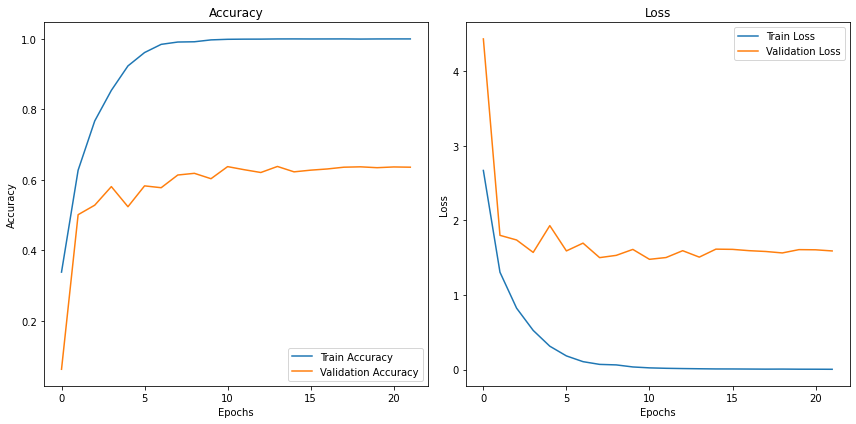

In [88]:
# CSV 파일 경로 설정
csv_file = 'history_resnet50_aug.csv'  # CSV Logger로 저장된 파일 경로

# CSV 파일 읽기
df = pd.read_csv(csv_file)

# 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss' 열을 확인
print(df.columns)

# 그래프 그리기
plt.figure(figsize=(12, 6))

# Train Accuracy와 Validation Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Train Loss와 Validation Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()

data aumentation 으로 gaussian noise를 사용한 그래프에서는 no_augumentation 한 그래프와 유사하게 
train 정확도가 1정도에 수렴하고 valiation accuaracy는 60%에 수렴하게 된다

In [84]:
checkpoint = ModelCheckpoint("resnet50_cutmix.h5", monitor='val_accuracy', verbose=1, save_best_only=False, mode='max', save_weights_only=True)
csv_logger = CSVLogger(filename = './history_resnet50_cutmix.csv', append = True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [85]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],    
)

history_resnet50_cutmix = resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [checkpoint,csv_logger]
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 3.7943 - accuracy: 0.2206 - val_loss: 3.2068 - val_accuracy: 0.2320

Epoch 00001: saving model to resnet50_cutmix.h5
Epoch 2/20
750/750 [==============================] - 160s 214ms/step - loss: 2.9202 - accuracy: 0.4420 - val_loss: 1.5278 - val_accuracy: 0.5723

Epoch 00002: saving model to resnet50_cutmix.h5
Epoch 3/20
750/750 [==============================] - 163s 217ms/step - loss: 2.6092 - accuracy: 0.5414 - val_loss: 1.3480 - val_accuracy: 0.6311

Epoch 00003: saving model to resnet50_cutmix.h5
Epoch 4/20
750/750 [==============================] - 161s 215ms/step - loss: 2.3864 - accuracy: 0.6174 - val_loss: 1.2594 - val_accuracy: 0.6511

Epoch 00004: saving model to resnet50_cutmix.h5
Epoch 5/20
750/750 [==============================] - 160s 214ms/step - loss: 2.2355 - accuracy: 0.6702 - val_loss: 1.3444 - val_accuracy: 0.6410

Epoch 00005: saving model to resnet50_cutmix.h5
Epoch 6/20
750/750 [=====

## cut Mix 그래프 

Index(['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object')


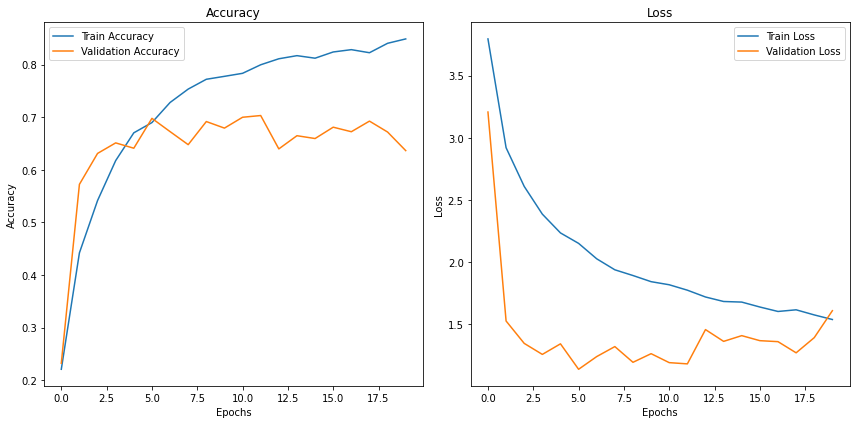

In [89]:
# CSV 파일 경로 설정
csv_file = 'history_resnet50_cutmix.csv'  # CSV Logger로 저장된 파일 경로

# CSV 파일 읽기
df = pd.read_csv(csv_file)

# 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss' 열을 확인
print(df.columns)

# 그래프 그리기
plt.figure(figsize=(12, 6))

# Train Accuracy와 Validation Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Train Loss와 Validation Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()

train loss 값과 validation loss 값이 17 epoch 정도에서 역전되는 상황이 발생하여 이 부근에서 overfiting이 의심된다.
train accuarcy가 1이 되지는 않고 80 부근에서 수렴하고 validation accuracy도 60~70 사이로 진폭이 발생한다.

In [120]:
checkpoint = ModelCheckpoint("resnet50_mixup.h5", monitor='val_accuracy', verbose=1, save_best_only=False, mode='max', save_weights_only=True)
csv_logger = CSVLogger(filename = './history_resnet50_mixup.csv', append = True)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [121]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],    
)

history_resnet50_mixup = resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [checkpoint,csv_logger]
)

Epoch 1/20
750/750 [==============================] - 161s 205ms/step - loss: 3.7219 - accuracy: 0.2418 - val_loss: 4.1352 - val_accuracy: 0.1146

Epoch 00001: saving model to resnet50_mixup.h5
Epoch 2/20
750/750 [==============================] - 174s 232ms/step - loss: 2.8791 - accuracy: 0.4724 - val_loss: 1.4144 - val_accuracy: 0.6069

Epoch 00002: saving model to resnet50_mixup.h5
Epoch 3/20
750/750 [==============================] - 161s 215ms/step - loss: 2.6074 - accuracy: 0.5861 - val_loss: 1.4121 - val_accuracy: 0.6049

Epoch 00003: saving model to resnet50_mixup.h5
Epoch 4/20
750/750 [==============================] - 168s 223ms/step - loss: 2.3903 - accuracy: 0.6552 - val_loss: 1.3970 - val_accuracy: 0.6188

Epoch 00004: saving model to resnet50_mixup.h5
Epoch 5/20
750/750 [==============================] - 165s 220ms/step - loss: 2.2471 - accuracy: 0.7122 - val_loss: 1.2379 - val_accuracy: 0.6544

Epoch 00005: saving model to resnet50_mixup.h5
Epoch 6/20
750/750 [==========

## MIxup 그래프

Index(['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object')


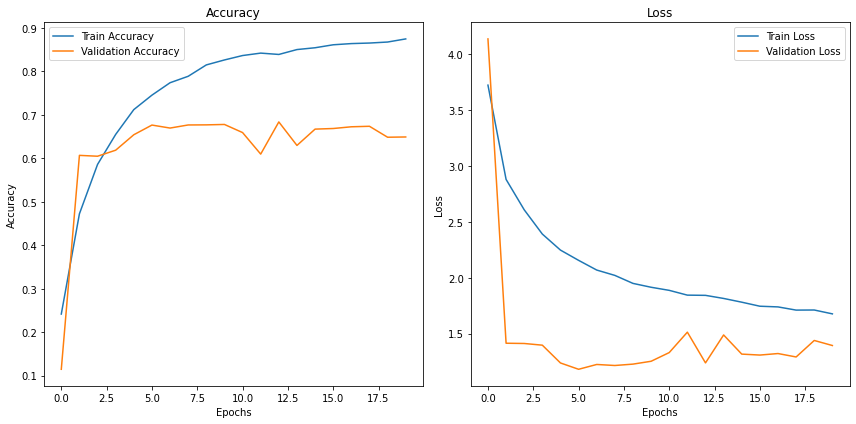

In [122]:
# CSV 파일 경로 설정
csv_file = 'history_resnet50_mixup.csv'  # CSV Logger로 저장된 파일 경로

# CSV 파일 읽기
df = pd.read_csv(csv_file)

# 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss' 열을 확인
print(df.columns)

# 그래프 그리기
plt.figure(figsize=(12, 6))

# Train Accuracy와 Validation Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Train Loss와 Validation Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()

 epoch 기준으로 train loss 와 validation loss가 역전되는 지점은 없고
train accuaryc는 80~90 사이로 발생하고 validation accuarcy는 60정도에 발생한다.

## 결과 그래프 시각화

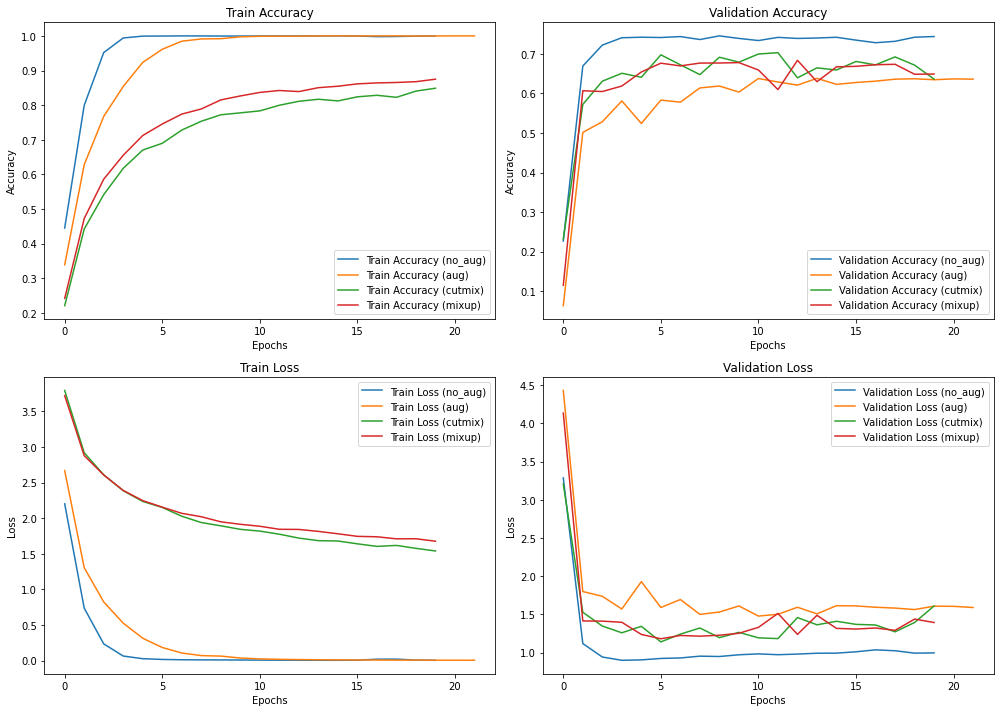

In [125]:
# CSV 파일 경로 설정
csv_files = {
    'no_aug': 'history_resnet50_no_aug.csv',
    'aug': 'history_resnet50_aug.csv',
    'cutmix': 'history_resnet50_cutmix.csv',
    'mixup': 'history_resnet50_mixup.csv'
}

# 각 CSV 파일에서 데이터를 불러옴
histories = {key: pd.read_csv(path) for key, path in csv_files.items()}

# 그래프 그리기
plt.figure(figsize=(14, 10))

# Train Accuracy 그래프
plt.subplot(2, 2, 1)
for label, history in histories.items():
    plt.plot(history['accuracy'], label=f'Train Accuracy ({label})')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation Accuracy 그래프
plt.subplot(2, 2, 2)
for label, history in histories.items():
    plt.plot(history['val_accuracy'], label=f'Validation Accuracy ({label})')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Train Loss 그래프
plt.subplot(2, 2, 3)
for label, history in histories.items():
    plt.plot(history['loss'], label=f'Train Loss ({label})')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Loss 그래프
plt.subplot(2, 2, 4)
for label, history in histories.items():
    plt.plot(history['val_loss'], label=f'Validation Loss ({label})')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 레이아웃을 조정하고 그래프 보여주기
plt.tight_layout()
plt.show()


|augumentation 방법 ||train accuracy||validation accuracy||train loss||validation loss|
|------|---|---||---||---||---|
|noaumentation ||0.99||0.74||0.007||0.99|
|gaussian augumentation||1.00||0.64||0.0045||1.59|
|only cutmix| |0.85| |0.64||1.5||1.6|
|only mixup ||0.87||0.65||1.68||1.39|



강건성과 성능은 trade-off 관계이다. 

고려해야 할 점은 강건성과 성능 간의 관계 및 강건성을 확인하는 방법입니다. 우리의 목표는 적대적 샘플 공격을 통해 이미지에 노이즈를 추가하여 모델 학습에 방해를 주고, 이를 통해 보다 일반화된 데이터에 대한 학습을 용이하게 하는 강건한 모델을 만드는 것입니다.

이러한 접근 방식을 통해 우리는 모델이 다양한 환경에서의 변형과 노이즈에 잘 대응할 수 있도록 훈련할 수 있습니다. 강건성을 확보하는 것은 모델이 실제 상황에서의 불확실성에 잘 적응하고, 예기치 못한 공격에 대한 저항력을 높이는 데 중요한 요소입니다.



## 회고
csv_logger callback를 쓰니깐 확실히 epoch마다 train, validation 값을 csv file로 볼 수 있어서 model 훈련을 중간에 멈추더라도 계속 이어나갈 수 있어서 좋았다.


시간을 단축해야 할 때

- learing rate를 조절 어느 정도 커지면 학습이 불안정을 감수하더라도 키워 볼 수 있다. 
- input image를 조절  30% 

앞으로 이런한 방법들로 학습 시간을 단축 시켜봐야 겠다.

